In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import h5py
from sunpy.coordinates.sun import carrington_rotation_time
import scipy.stats as st
import datetime
from astropy.time import Time
import copy

mpl.rcParams.update({'font.size': 14})

In [2]:
def load_ssn_sai():
    """
    Function to load in the monthly sunspot number data and compute the Solar Activity Index (SAI)
    Returns:
    ssn_df: A Pandas dataframe with the SSN and SAI data.
    """

    # Download from http://www.sidc.be/silso/DATA/SN_m_tot_V2.0.csv
    filepath = "C:/Users/yq904481/research/repos/CME_transit_climatology/data/SN_m_tot_V2.0.csv"

    col_specification = [(0, 4), (5, 7), (8,16),(17,23),(24,29),(30,35)]
    ssn_df = pd.read_fwf(filepath, colspecs=col_specification,header=None)
    dfdt = np.empty_like(ssn_df[0], dtype=datetime.datetime)
    dftime = np.empty_like(ssn_df[0], dtype=Time)

    for i in range(0,len(ssn_df)):
        date_string = str(int(ssn_df[0][i])) + '-' + str(int(ssn_df[1][i])) + '-15'

        dfdt[i] = datetime.datetime(int(ssn_df[0][i]),int(ssn_df[1][i]),15)
        dftime[i] = Time(date_string, format='iso')

    #replace the index with the datetime objects
    ssn_df['datetime'] = dfdt
    ssn_df['time'] = dftime
    ssn_df["fracyear"] = ssn_df.apply(lambda row: row["time"].decimalyear, axis=1)
    ssn_df['ssn'] = ssn_df[3]
    ssn_df['jd'] = ssn_df.apply(lambda row: row["time"].jd, axis=1)

    #delete the unwanted columns
    ssn_df.drop(0,axis=1,inplace=True)
    ssn_df.drop(1,axis=1,inplace=True)
    ssn_df.drop(2,axis=1,inplace=True)
    ssn_df.drop(3,axis=1,inplace=True)
    ssn_df.drop(4,axis=1,inplace=True)
    ssn_df.drop(5,axis=1,inplace=True)

    #add the 13-month running smooth
    window = 13*30
    temp = ssn_df.rolling(str(window)+'D', on='datetime').mean()
    ssn_df['smooth'] = np.interp(ssn_df['jd'],temp['jd'],temp['ssn'], left =np.nan, right =np.nan)
    #drop the incomplete window at the start
    mask = ssn_df['jd'] < ssn_df['jd'].loc[0] + window/2
    ssn_df.loc[mask, 'smooth'] = np.nan

    #add in a solar activity index, which normalises the cycle magnitude
    #approx solar cycle length, in months
    nwindow = int(11*12)
    #find maximum value in a 1-solar cycle bin centred on current time
    ssn_df['rollingmax'] = ssn_df.rolling(nwindow, center = True).max()['smooth']
    #fill the max value at the end of the series
    fillval_end = ssn_df['rollingmax'].dropna().values[-1]
    fillval_start = ssn_df['rollingmax'].dropna().values[0]
    ssn_df['rollingmax'] = ssn_df['rollingmax'].fillna(fillval_end)
    #drop the incomplete window at the start
    mask = ssn_df['jd'] < (ssn_df['jd'].loc[0] + 11*365.25/2)
    ssn_df.loc[mask, 'rollingmax'] = fillval_start
    #create a Solar Activity Index, as SSN normalised to the max smoothed value in
    #1-sc window centred on current tim
    ssn_df['sai'] = ssn_df['smooth'] / ssn_df['rollingmax']
    return ssn_df

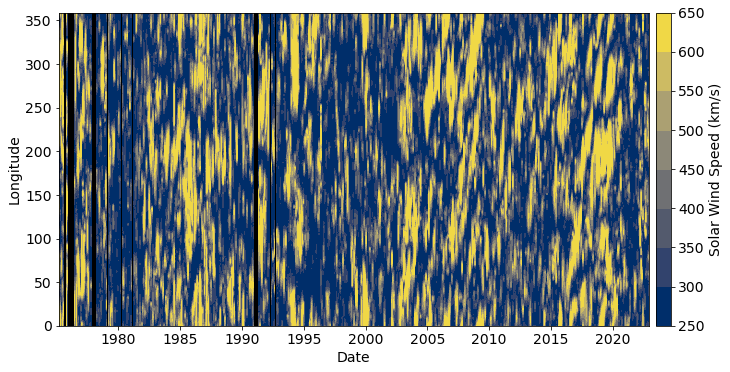

In [3]:
def solarwind_time_longitude_map_plot():
    """
    Produce a time-longitude plot of the MAS equatorial solar wind speed, to show how solar wind model boundary conditions change in time.
    """

    # load in the CME transit time data
    data_path = "C:/Users/yq904481/research/repos/CME_transit_climatology/data/output/CME_transit_data.hdf5"
    data = h5py.File(data_path, 'r')

    cr_keys = data.keys()
    # Make array of CR numbers from the keys -  this is discontinuous.
    cr_nums = np.array([int(c.split("_")[1]) for c in cr_keys])

    cr_nums_pad = np.arange(cr_nums.min(), cr_nums.max() + 1, 1)
    cr_time_pad = carrington_rotation_time(cr_nums_pad + 0.5)
    vsw_bc = []

    for cr_num in cr_nums_pad:
        cr_tag = "CR_{}".format(cr_num)

        if cr_tag in cr_keys:
            # Get BC variability
            vsw_bc.append(data[cr_tag + '/vr_in'][:])
        else:
            vsw_bc.append(np.nan*np.ones(360))

    vsw = np.array(vsw_bc)
    lons = np.arange(0,360,1)

    fig, ax = plt.subplots(figsize=(10,5), facecolor='white')
    ax.set_facecolor('k')
    levels = np.arange(250, 700, 50)
    cmap = copy.copy(mpl.cm.get_cmap('cividis'))
    cmap.set_bad(color='k', alpha=1)

    cnt = ax.contourf(cr_time_pad.datetime, lons, vsw.T, levels=levels, cmap=cmap, vmin=levels[0], vmax=levels[-1])
    ax.set_xlabel('Date')
    ax.set_ylabel('Longitude')

    cbar = fig.colorbar(cnt, ax=ax, pad=0.01)
    cbar.ax.set_ylabel('Solar Wind Speed (km/s)')

    fig.subplots_adjust(left=0.075, bottom=0.11, right=1.05, top=0.98)
    fig_name = "C:/Users/yq904481/research/repos/CME_transit_climatology/figures/MAS_Vsw_equator_timeseries.pdf"
    fig.savefig(fig_name)
    fig_name = "C:/Users/yq904481/research/repos/CME_transit_climatology/figures/MAS_Vsw_equator_timeseries.png"
    fig.savefig(fig_name)

    data.close()
    return

solarwind_time_longitude_map_plot()

Figure 1. A time-longitude map of the equatorial solar wind speed from the MAS coronal model output. In this work these data are used as the boundary conditions to the HUXt solar wind simulations. Black vertical stripes mark Carrington rotations where the MAS solutions were unavailable.

In [4]:
def load_reduced_transit_data():
    """
    Function to load in the transit simulation data for all Carrington rotations and compute the median and interquartile range for each rotataion.
    Then the SSN and SAI are interpolated onto the CR times. This is done for both the average and fast CME scenarios.
    Returns:
    cme_avg: Pandas dataframe of transit time statistics and solar activity measures for the average CME scenario
    cme_fst: Pandas dataframe of transit time statistics and solar activity measures for the fast CME scenario
    """

    data_path = "C:/Users/yq904481/research/repos/CME_transit_climatology/data/output/CME_transit_data.hdf5"
    data = h5py.File(data_path, 'r')

    cr_keys = data.keys()
    # Make array of CR numbers from the keys -  this is discontinuous.
    cr_nums = np.array([int(c.split("_")[1]) for c in cr_keys])
    cr_time = carrington_rotation_time(cr_nums+0.5)

    for cme_type in ["cme_average", "cme_fast"]:

        transit_avg = np.zeros(len(cr_nums))
        transit_var = np.zeros(len(cr_nums))
        transit_q1  = np.zeros(len(cr_nums))
        transit_q9  = np.zeros(len(cr_nums))
        vsw_mas_var = np.zeros(len(cr_nums))

        for i, (cr_key, cr_data) in enumerate(data.items()):

            # Get BC variability
            vsw_mas_var[i] = cr_data['vr_in_std'][()]

            # Convert transits from days to hours
            transits = 24*cr_data[cme_type + '/t_transit'][:]
            transit_avg[i] = np.nanmedian(transits)
            transit_var[i] = st.iqr(transits, nan_policy="omit")
            quantiles = np.nanpercentile(transits, [10, 90])
            transit_q1[i] = quantiles[0]
            transit_q9[i] = quantiles[1]

        id_good = np.isfinite(transit_var) & np.isfinite(transit_avg)
        cr_nums_sub = cr_nums[id_good]
        cr_time_sub = cr_time[id_good]
        transit_avg = transit_avg[id_good]
        transit_q1 = transit_q1[id_good]
        transit_q9 = transit_q9[id_good]
        transit_var = transit_var[id_good]
        vsw_mas_var = vsw_mas_var[id_good]

        df = pd.DataFrame({'cr_num':cr_nums_sub, 'datetime':cr_time_sub.datetime, 'jd':cr_time_sub.jd, 'avg':transit_avg, 'iqr':transit_var,
                           'q1':transit_q1, 'q9':transit_q9, 'vsw_var':vsw_mas_var})

        if cme_type == 'cme_average':
            cme_avg = df.copy()
        elif cme_type == 'cme_fast':
            cme_fst = df.copy()

        del df

    # Load SSN and SAI
    ssn = load_ssn_sai()

    # Interpolate SAI onto the CME series
    cme_avg['sai'] = np.interp(cme_avg['jd'], ssn['jd'], ssn['sai'])
    cme_fst['sai'] = np.interp(cme_fst['jd'], ssn['jd'], ssn['sai'])

    cme_avg['ssn'] = np.interp(cme_avg['jd'], ssn['jd'], ssn['ssn'])
    cme_fst['ssn'] = np.interp(cme_fst['jd'], ssn['jd'], ssn['ssn'])

    data.close()
    return cme_avg, cme_fst

C:\Users\yq904481\Anaconda\envs\huxt\lib\site-packages\erfa\core.py:154: ErfaWarning: ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
C:\Users\yq904481\Anaconda\envs\huxt\lib\site-packages\erfa\core.py:154: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
C:\Users\yq904481\Anaconda\envs\huxt\lib\site-packages\erfa\core.py:154: ErfaWarning: ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
C:\Users\yq904481\Anaconda\envs\huxt\lib\site-packages\erfa\core.py:154: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


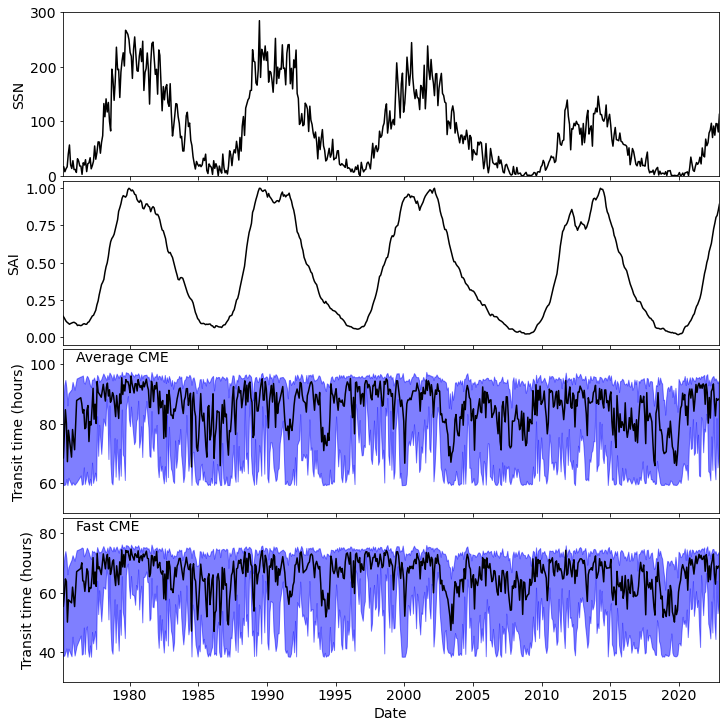

In [5]:
def solar_activity_and_transients_time_series():
    """
    Time series plot showing the evolution of SSN, SAI, and medians of transit time over each Carrington rotation of the study.
    Returns:

    """
    ssn = load_ssn_sai()
    cme_avg, cme_fst = load_reduced_transit_data()

    fig, ax = plt.subplots(4,1, figsize=(10,10), facecolor='white')

    ax[0].plot(ssn['datetime'], ssn['ssn'], 'k-')
    ax[1].plot(ssn['datetime'], ssn['sai'], 'k-')

    for a, cme, label in zip(ax[2:], [cme_avg, cme_fst], ['Average CME', 'Fast CME']):
        a.plot(cme_avg['datetime'], cme['avg'], 'k-', zorder=2)
        a.fill_between(cme_avg['datetime'], cme['q1'], cme['q9'], color='b', alpha=0.5, zorder=1)
        a.text(0.02, 0.925, label, transform=a.transAxes, fontsize=14)

    for a in ax:
        a.set_xlim(cme_avg['datetime'].min(), cme_avg['datetime'].max())

    for a in ax[:-1]:
        a.set_xticklabels([])

    ax[0].set_ylim(0,300)
    ax[2].set_ylim(50,105)
    ax[3].set_ylim(30,85)

    ax[-1].set_xlabel('Date', fontsize=14)
    ax[0].set_ylabel('SSN', fontsize=14)
    ax[1].set_ylabel('SAI', fontsize=14)
    ax[2].set_ylabel('Transit time (hours)', fontsize=14)
    ax[3].set_ylabel('Transit time (hours)', fontsize=14)

    fig.subplots_adjust(left=0.08, bottom=0.06, right=0.99, top=0.99, hspace=0.03)
    fig_name = "C:/Users/yq904481/research/repos/CME_transit_climatology/figures/ssn_sai_cme_timeseries.pdf"
    fig.savefig(fig_name)
    fig_name = "C:/Users/yq904481/research/repos/CME_transit_climatology/figures/ssn_sai_cme_timeseries.png"
    fig.savefig(fig_name)
    return

solar_activity_and_transients_time_series()

C:\Users\yq904481\Anaconda\envs\huxt\lib\site-packages\erfa\core.py:154: ErfaWarning: ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
C:\Users\yq904481\Anaconda\envs\huxt\lib\site-packages\erfa\core.py:154: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


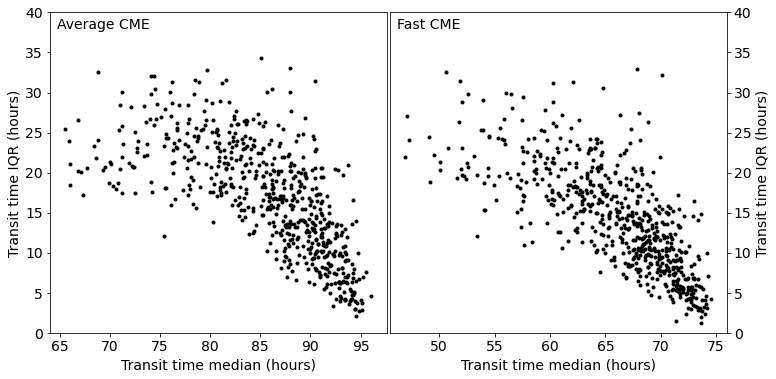

In [6]:
def transit_median_iqr_scatter():
    """
    Scatter plots of the CR median transit time vs transit time IQR for the average and fast CME scenarios
    Returns:

    """
    cme_avg, cme_fst = load_reduced_transit_data()

    fig, ax = plt.subplots(1,2, figsize=(10,5))
    for a, cme, label in zip(ax, [cme_avg, cme_fst], ['Average CME', 'Fast CME']):
        a.plot(cme['avg'], cme['iqr'], 'k.')
        a.set_xlabel('Transit time median (hours)', fontsize=14)
        a.set_ylabel('Transit time IQR (hours)', fontsize=14)
        a.set_ylim(0,40)
        a.text(0.02, 0.95, label, transform=a.transAxes, fontsize=14)

    ax[1].yaxis.tick_right()
    ax[1].yaxis.set_label_position('right')

    fig.subplots_adjust(left=0.05, bottom=0.1, right=0.99, top=0.99, wspace=0.01)
    fig_name = "C:/Users/yq904481/research/repos/CME_transit_climatology/figures/cme_transit_time_median_iqr_scatter.pdf"
    fig.savefig(fig_name)
    fig_name = "C:/Users/yq904481/research/repos/CME_transit_climatology/figures/cme_transit_time_median_iqr_scatter.png"
    fig.savefig(fig_name)
    return

transit_median_iqr_scatter()

C:\Users\yq904481\Anaconda\envs\huxt\lib\site-packages\erfa\core.py:154: ErfaWarning: ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
C:\Users\yq904481\Anaconda\envs\huxt\lib\site-packages\erfa\core.py:154: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


Average CME
Total samples: 622
Samples in low tercile: 207
Samples in mid tercile: 207
Samples in high tercile: 208
Fast CME
Total samples: 622
Samples in low tercile: 207
Samples in mid tercile: 207
Samples in high tercile: 208


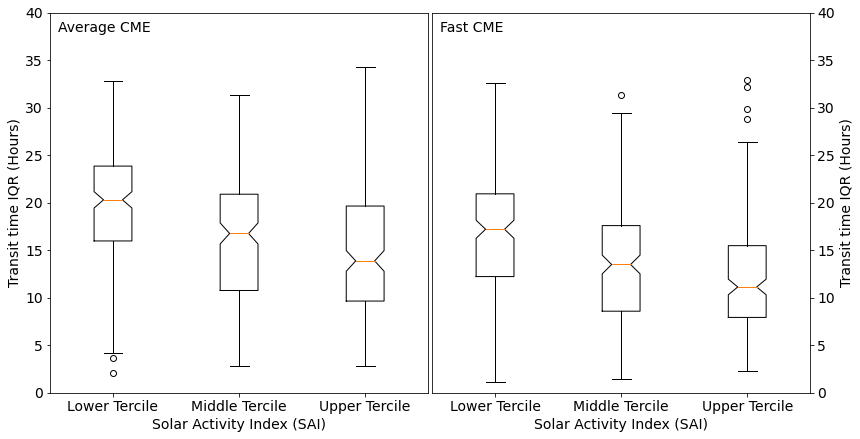

In [7]:
def boxplot_sai_transit_iqr():
    """
    Produce a boxplot of the distributions of the transit time IQR in each Carrington rotation partitioned by the terciles of the SAI distribution
    Returns:

    """
    cme_avg, cme_fst = load_reduced_transit_data()

    fig, ax = plt.subplots(1,2, figsize=(12, 6), facecolor='white')

    for a, cme, cme_label in zip(ax, [cme_avg, cme_fst], ['Average CME', 'Fast CME']):

        terciles = cme['sai'].quantile([0.333,0.666]).values

        id_low = cme['sai'] <= terciles[0]
        id_mid = (cme['sai'] > terciles[0]) & (cme['sai'] <= terciles[1])
        id_high = cme['sai'] > terciles[1]

        print(cme_label)
        print('Total samples: {}'.format(len(id_low)))
        print("Samples in low tercile: {}".format(np.sum(id_low)))
        print("Samples in mid tercile: {}".format(np.sum(id_mid)))
        print("Samples in high tercile: {}".format(np.sum(id_high)))

        boxplot_data = [cme.loc[id_low, 'iqr'], cme.loc[id_mid, 'iqr'], cme.loc[id_high, 'iqr']]
        labels = ['Lower Tercile', 'Middle Tercile', 'Upper Tercile']
        a.boxplot(boxplot_data, notch=True, labels=labels)
        a.text(0.02, 0.95, cme_label, transform=a.transAxes)

        a.set_xlabel('Solar Activity Index (SAI)')
        a.set_ylabel('Transit time IQR (Hours)')
        a.set_ylim(0,40)

    ax[1].yaxis.tick_right()
    ax[1].yaxis.set_label_position('right')

    fig.subplots_adjust(left=0.07, bottom=0.1, right=0.95, top=0.98, wspace=0.01)
    fig_name = "C:/Users/yq904481/research/repos/CME_transit_climatology/figures/boxplot_transit_time_iqr_sai.pdf"
    fig.savefig(fig_name)
    fig_name = "C:/Users/yq904481/research/repos/CME_transit_climatology/figures/boxplot_transit_time_iqr_sai.png"
    fig.savefig(fig_name)
    return

boxplot_sai_transit_iqr()

C:\Users\yq904481\Anaconda\envs\huxt\lib\site-packages\erfa\core.py:154: ErfaWarning: ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
C:\Users\yq904481\Anaconda\envs\huxt\lib\site-packages\erfa\core.py:154: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


Average CME
Total samples: 622
Samples in low tercile: 207
Samples in mid tercile: 207
Samples in high tercile: 208
Fast CME
Total samples: 622
Samples in low tercile: 207
Samples in mid tercile: 207
Samples in high tercile: 208


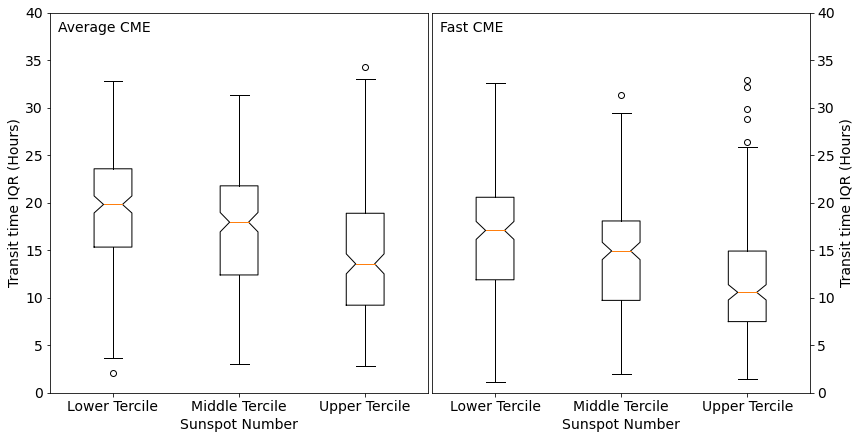

In [8]:
def boxplot_ssn_transit_iqr():
    """
    Produce a boxplot of the distributions of the transit time IQR in each Carrington rotation partitioned by the terciles of the SSN distribution
    Returns:

    """
    cme_avg, cme_fst = load_reduced_transit_data()

    fig, ax = plt.subplots(1,2, figsize=(12, 6), facecolor='white')

    for a, cme, cme_label in zip(ax, [cme_avg, cme_fst], ['Average CME', 'Fast CME']):

        terciles = cme['ssn'].quantile([0.333,0.666]).values

        id_low = cme['ssn'] <= terciles[0]
        id_mid = (cme['ssn'] > terciles[0]) & (cme['ssn'] <= terciles[1])
        id_high = cme['ssn'] > terciles[1]

        print(cme_label)
        print('Total samples: {}'.format(len(id_low)))
        print("Samples in low tercile: {}".format(np.sum(id_low)))
        print("Samples in mid tercile: {}".format(np.sum(id_mid)))
        print("Samples in high tercile: {}".format(np.sum(id_high)))

        boxplot_data = [cme.loc[id_low, 'iqr'], cme.loc[id_mid, 'iqr'], cme.loc[id_high, 'iqr']]
        labels = ['Lower Tercile', 'Middle Tercile', 'Upper Tercile']
        a.boxplot(boxplot_data, notch=True, labels=labels)
        a.text(0.02, 0.95, cme_label, transform=a.transAxes)

        a.set_xlabel('Sunspot Number')
        a.set_ylabel('Transit time IQR (Hours)')
        a.set_ylim(0,40)

    ax[1].yaxis.tick_right()
    ax[1].yaxis.set_label_position('right')

    fig.subplots_adjust(left=0.07, bottom=0.1, right=0.95, top=0.98, wspace=0.01)
    fig_name = "C:/Users/yq904481/research/repos/CME_transit_climatology/figures/boxplot_transit_time_iqr_ssn.pdf"
    fig.savefig(fig_name)
    fig_name = "C:/Users/yq904481/research/repos/CME_transit_climatology/figures/boxplot_transit_time_iqr_ssn.png"
    fig.savefig(fig_name)
    return

boxplot_ssn_transit_iqr()

C:\Users\yq904481\Anaconda\envs\huxt\lib\site-packages\erfa\core.py:154: ErfaWarning: ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
C:\Users\yq904481\Anaconda\envs\huxt\lib\site-packages\erfa\core.py:154: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


Average CME
Total samples: 622
Samples in low tercile: 207
Samples in mid tercile: 207
Samples in high tercile: 208
Fast CME
Total samples: 622
Samples in low tercile: 207
Samples in mid tercile: 207
Samples in high tercile: 208


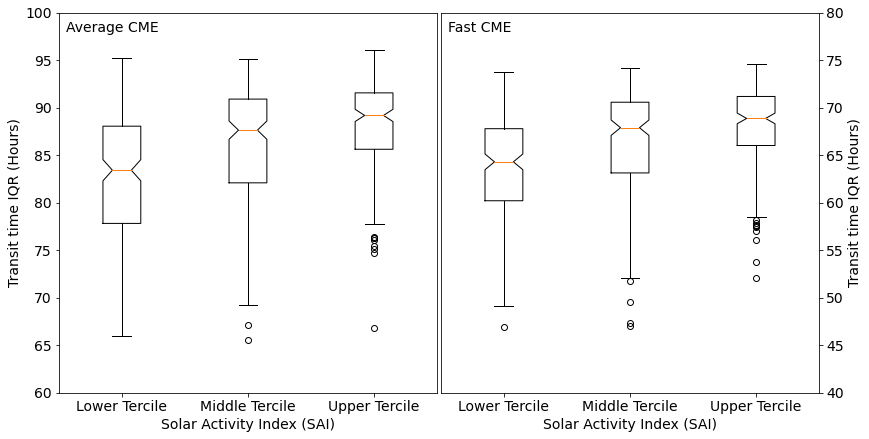

In [9]:
def boxplot_sai_transit_median():
    """
    Produce a boxplot of the distributions of the transit time median in each Carrington rotation partitioned by the terciles of the SAI distribution
    Returns:

    """
    cme_avg, cme_fst = load_reduced_transit_data()

    fig, ax = plt.subplots(1,2, figsize=(12, 6), facecolor='white')

    for a, cme, cme_label in zip(ax, [cme_avg, cme_fst], ['Average CME', 'Fast CME']):

        terciles = cme['sai'].quantile([0.333,0.666]).values

        id_low = cme['sai'] <= terciles[0]
        id_mid = (cme['sai'] > terciles[0]) & (cme['sai'] <= terciles[1])
        id_high = cme['sai'] > terciles[1]

        print(cme_label)
        print('Total samples: {}'.format(len(id_low)))
        print("Samples in low tercile: {}".format(np.sum(id_low)))
        print("Samples in mid tercile: {}".format(np.sum(id_mid)))
        print("Samples in high tercile: {}".format(np.sum(id_high)))

        boxplot_data = [cme.loc[id_low, 'avg'], cme.loc[id_mid, 'avg'], cme.loc[id_high, 'avg']]
        labels = ['Lower Tercile', 'Middle Tercile', 'Upper Tercile']
        a.boxplot(boxplot_data, notch=True, labels=labels)
        a.text(0.02, 0.95, cme_label, transform=a.transAxes)

        a.set_xlabel('Solar Activity Index (SAI)')
        a.set_ylabel('Transit time IQR (Hours)')

    ax[0].set_ylim(60,100)
    ax[1].set_ylim(40,80)
    ax[1].yaxis.tick_right()
    ax[1].yaxis.set_label_position('right')

    fig.subplots_adjust(left=0.07, bottom=0.1, right=0.95, top=0.98, wspace=0.01)
    fig_name = "C:/Users/yq904481/research/repos/CME_transit_climatology/figures/boxplot_transit_time_median_sai.pdf"
    fig.savefig(fig_name)
    fig_name = "C:/Users/yq904481/research/repos/CME_transit_climatology/figures/boxplot_transit_time_median_sai.png"
    fig.savefig(fig_name)
    return

boxplot_sai_transit_median()

In [10]:
def load_transit_data():
    """
    Function to load in the transit simulation data for all Carrington rotations and compute the median and interquartile range for each rotataion.
    Then the SSN and SAI are interpolated onto the CR times. This is done for both the average and fast CME scenarios.
    Returns:
    cme_avg: Pandas dataframe of transit time statistics and solar activity measures for the average CME scenario
    cme_fst: Pandas dataframe of transit time statistics and solar activity measures for the fast CME scenario
    """

    data_path = "C:/Users/yq904481/research/repos/CME_transit_climatology/data/output/CME_transit_data.hdf5"
    data = h5py.File(data_path, 'r')

    cr_keys = data.keys()
    # Make array of CR numbers from the keys -  this is discontinuous.
    cr_nums = np.array([int(c.split("_")[1]) for c in cr_keys])

    for cme_type in ["cme_average", "cme_fast"]:

        transits_agg = np.array([])
        cr_nums_agg = np.array([])

        for i, (cr_key, cr_data) in enumerate(data.items()):

            # Convert transits from days to hours
            transits = 24*cr_data[cme_type + '/t_transit'][:]
            transits_agg = np.append(transits_agg, transits)
            cr_nums_agg = np.append(cr_nums_agg, cr_nums[i]*np.ones(transits.size))

        id_good = np.isfinite(transits_agg)
        cr_nums_agg = cr_nums_agg[id_good]
        transits_agg = transits_agg[id_good]

        cr_time_agg = carrington_rotation_time(cr_nums_agg + 0.5)

        df = pd.DataFrame({'cr_num':cr_nums_agg, 'datetime':cr_time_agg.datetime, 'jd':cr_time_agg.jd, 'transits':transits_agg})

        if cme_type == 'cme_average':
            cme_avg = df.copy()
        elif cme_type == 'cme_fast':
            cme_fst = df.copy()

        del df

    # Load SSN and SAI
    ssn = load_ssn_sai()

    # Interpolate SAI onto the CME series
    cme_avg['sai'] = np.interp(cme_avg['jd'], ssn['jd'], ssn['sai'])
    cme_fst['sai'] = np.interp(cme_fst['jd'], ssn['jd'], ssn['sai'])

    cme_avg['ssn'] = np.interp(cme_avg['jd'], ssn['jd'], ssn['ssn'])
    cme_fst['ssn'] = np.interp(cme_fst['jd'], ssn['jd'], ssn['ssn'])

    data.close()
    return cme_avg, cme_fst

C:\Users\yq904481\Anaconda\envs\huxt\lib\site-packages\erfa\core.py:154: ErfaWarning: ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
C:\Users\yq904481\Anaconda\envs\huxt\lib\site-packages\erfa\core.py:154: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


Average CME
Total samples: 16794
Samples in low tercile: 5616
Samples in mid tercile: 5589
Samples in high tercile: 5589
Fast CME
Total samples: 16794
Samples in low tercile: 5616
Samples in mid tercile: 5589
Samples in high tercile: 5589


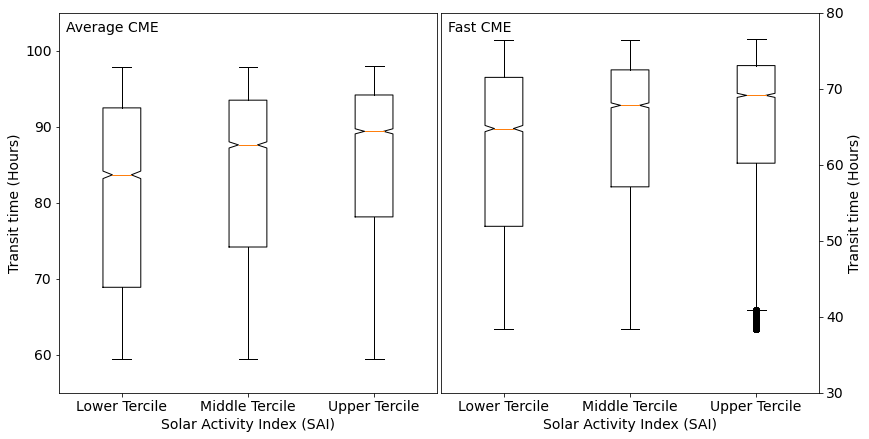

In [11]:
def boxplot_transits_sai():
    """
    Boxplot of the transit time distribution aggregated over all Carrington rotations, separated by the terciles of SAI.
    Returns:
    """

    cme_avg, cme_fst = load_transit_data()

    fig, ax = plt.subplots(1,2, figsize=(12, 6), facecolor='white')

    for a, cme, cme_label in zip(ax, [cme_avg, cme_fst], ['Average CME', 'Fast CME']):

        terciles = cme['sai'].quantile([0.333,0.666]).values

        id_low = cme['sai'] <= terciles[0]
        id_mid = (cme['sai'] > terciles[0]) & (cme['sai'] <= terciles[1])
        id_high = cme['sai'] > terciles[1]

        print(cme_label)
        print('Total samples: {}'.format(len(id_low)))
        print("Samples in low tercile: {}".format(np.sum(id_low)))
        print("Samples in mid tercile: {}".format(np.sum(id_mid)))
        print("Samples in high tercile: {}".format(np.sum(id_high)))

        boxplot_data = [cme.loc[id_low, 'transits'], cme.loc[id_mid, 'transits'], cme.loc[id_high, 'transits']]
        labels = ['Lower Tercile', 'Middle Tercile', 'Upper Tercile']
        a.boxplot(boxplot_data, notch=True, labels=labels)
        a.text(0.02, 0.95, cme_label, transform=a.transAxes)

        a.set_xlabel('Solar Activity Index (SAI)')
        a.set_ylabel('Transit time (Hours)')

    ax[0].set_ylim(55, 105)
    ax[1].set_ylim(30, 80)

    ax[1].yaxis.tick_right()
    ax[1].yaxis.set_label_position('right')

    fig.subplots_adjust(left=0.07, bottom=0.1, right=0.95, top=0.98, wspace=0.01)
    fig_name = "C:/Users/yq904481/research/repos/CME_transit_climatology/figures/boxplot_transit_time_all_sai.pdf"
    fig.savefig(fig_name)
    fig_name = "C:/Users/yq904481/research/repos/CME_transit_climatology/figures/boxplot_transit_time_all_sai.png"
    fig.savefig(fig_name)
    return

boxplot_transits_sai()